In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
#from adm1.ode import ADM1_ODE
import scipy
# Import custom plotting functions
from plot_utils import plot_biomass_and_substrate, plot_gas_and_inhibition, plot_ph

In [2]:
q_ad_init=500               # Initial influent flow rate [m^3/d]
density=1000                # Influent density [kg/m^3]
water_fraction=0.97         # Fraction of water in influent
evaporated_water_volume=350 # Water lost to evaporation [m^3/d]
mixing_ratio=0.99999  # Fraction for feed 1 # feed1 / total (can be overridden per scenario)
OLR=5                     # Organic Loading Rate [kg VS/m3/d]

In [3]:
# Physico-chemical parameter values from the Rosen et al (2006) BSM2 report
T_ad =  308.15 #K
T_base =  298.15 #K
T_op =  308.15 #k ##T_ad #=35 C

In [4]:
from adm1.influent import reactor_setup
reactor = reactor_setup(q_ad_init, density, water_fraction, evaporated_water_volume, mixing_ratio, OLR)

In [5]:
# --- Set up reactor for this scenario ---

q_ad = reactor['q_ad']
q_ad1 = reactor['q_ad1']
q_ad2 = reactor['q_ad2']
VS = reactor['vs_frac']
VS_in = reactor['VS_in']
HRT = reactor['HRT']
V_liq = reactor['V_liq']
V_gas = reactor['V_gas']
V_ad = reactor['V_ad']
OLR = reactor['OLR']
density = reactor['density']
water_fraction = reactor['water_fraction']
evaporated_water_volume = reactor['evaporated_water_volume']
mixing_ratio=reactor['mixing_ratio']

# --- End  Reactor Setup ---

In [6]:
from adm1.influent import get_influent
influent = get_influent(mixing_ratio)

In [7]:
S_su_in = influent['S_su_in']
S_aa_in = influent['S_aa_in']
S_fa_in = influent['S_fa_in']
S_va_in = influent['S_va_in']
S_bu_in = influent['S_bu_in']
S_pro_in = influent['S_pro_in']
S_ac_in = influent['S_ac_in']
S_h2_in = influent['S_h2_in']
S_ch4_in = influent['S_ch4_in']
S_IC_in = influent['S_IC_in']
S_IN_in = influent['S_IN_in']
S_I_in = influent['S_I_in']
X_xc1_in = influent['X_xc1_in']
X_ch1_in = influent['X_ch1_in']
X_pr1_in = influent['X_pr1_in']
X_li1_in = influent['X_li1_in']
X_xc2_in = influent['X_xc2_in']
X_ch2_in = influent['X_ch2_in']
X_pr2_in = influent['X_pr2_in']
X_li2_in = influent['X_li2_in']
X_su_in = influent['X_su_in']
X_aa_in = influent['X_aa_in']
X_fa_in = influent['X_fa_in']
X_c4_in = influent['X_c4_in']
X_pro_in = influent['X_pro_in']
X_ac_in = influent['X_ac_in']
X_h2_in = influent['X_h2_in']
X_I_in = influent['X_I_in']
S_cation_in = influent['S_cation_in']
S_anion_in = influent['S_anion_in']

state_input = [S_su_in,
              S_aa_in,
              S_fa_in,
              S_va_in,
              S_bu_in,
              S_pro_in,
              S_ac_in,
              S_h2_in,
              S_ch4_in,
              S_IC_in,
              S_IN_in,
              S_I_in,
              X_xc1_in,
              X_ch1_in,
              X_pr1_in,
              X_li1_in,
              X_xc2_in,
              X_ch2_in,
              X_pr2_in,
              X_li2_in,
              X_su_in,
              X_aa_in,
              X_fa_in,
              X_c4_in,
              X_pro_in,
              X_ac_in,
              X_h2_in,
              X_I_in,
              S_cation_in,
              S_anion_in]


########################################


input_labels = [
    "S_su_in", "S_aa_in", "S_fa_in", "S_va_in", "S_bu_in", "S_pro_in", "S_ac_in", 
    "S_h2_in", "S_ch4_in", "S_IC_in", "S_IN_in", "S_I_in", "X_xc1_in", "X_ch1_in", 
    "X_pr1_in", "X_li1_in", "X_xc2_in", "X_ch2_in", "X_pr2_in", "X_li2_in", "X_su_in", 
    "X_aa_in", "X_fa_in", "X_c4_in", "X_pro_in", "X_ac_in", "X_h2_in", "X_I_in", 
    "S_cation_in", "S_anion_in"
]

print("\nState Input Values:")
for label, value in zip(input_labels, state_input):
    print(f"{label}: {value}")
    


State Input Values:
S_su_in: 0.001
S_aa_in: 0.001
S_fa_in: 0.001
S_va_in: 0.001
S_bu_in: 0.001
S_pro_in: 0.001
S_ac_in: 0.001
S_h2_in: 1e-08
S_ch4_in: 1e-05
S_IC_in: 0.04
S_IN_in: 0.01
S_I_in: 0.02
X_xc1_in: 0.0
X_ch1_in: 20.056799429999998
X_pr1_in: 12.67387326
X_li1_in: 9.99690003
X_xc2_in: 0.0
X_ch2_in: 0.002053936799990653
X_pr2_in: 0.00047838527999782284
X_li2_in: 6.759791999969236e-05
X_su_in: 0.0
X_aa_in: 0.0
X_fa_in: 0.0
X_c4_in: 0.0
X_pro_in: 0.0
X_ac_in: 0.0
X_h2_in: 0.0
X_I_in: 25.0
S_cation_in: 0.04
S_anion_in: 0.02


In [8]:
from adm1.initial_state import get_initial_state
initial_state = get_initial_state(mixing_ratio)

In [9]:
S_su=initial_state['S_su']
S_aa=initial_state['S_aa']
S_fa=initial_state['S_fa']
S_va=initial_state['S_va']
S_bu=initial_state['S_bu']
S_pro=initial_state['S_pro']
S_ac=initial_state['S_ac']
S_h2=initial_state['S_h2']
S_ch4=initial_state['S_ch4']
S_IC=initial_state['S_IC']
S_IN=initial_state['S_IN']
S_I=initial_state['S_I']
X_xc1=initial_state['X_xc1']
X_ch1=initial_state['X_ch1']
X_pr1=initial_state['X_pr1']
X_li1=initial_state['X_li1']
X_xc2=initial_state['X_xc2']
X_ch2=initial_state['X_ch2']
X_pr2=initial_state['X_pr2']
X_li2=initial_state['X_li2']
X_su=initial_state['X_su']
X_aa=initial_state['X_aa']
X_fa=initial_state['X_fa']
X_c4=initial_state['X_c4']
X_pro=initial_state['X_pro']
X_ac=initial_state['X_ac']
X_h2=initial_state['X_h2']
X_I=initial_state['X_I']
S_cation=initial_state['S_cation']
S_anion=initial_state['S_anion']
pH=initial_state['pH']
S_H_ion=initial_state['S_H_ion']
S_va_ion=initial_state['S_va_ion']
S_bu_ion=initial_state['S_bu_ion']
S_pro_ion=initial_state['S_pro_ion']
S_ac_ion=initial_state['S_ac_ion']
S_hco3_ion=initial_state['S_hco3_ion']
S_nh3=initial_state['S_nh3']
S_nh4_ion=initial_state['S_nh4_ion']
S_co2=initial_state['S_co2']
S_gas_h2=initial_state['S_gas_h2']
S_gas_ch4=initial_state['S_gas_ch4']
S_gas_co2=initial_state['S_gas_co2']

state_zero = [S_su,
              S_aa,
              S_fa,
              S_va,
              S_bu,
              S_pro,
              S_ac,
              S_h2,
              S_ch4,
              S_IC,
              S_IN,
              S_I,
              X_xc1,
              X_ch1,
              X_pr1,
              X_li1,
              X_xc2,
              X_ch2,
              X_pr2,
              X_li2,
              X_su,
              X_aa,
              X_fa,
              X_c4,
              X_pro,
              X_ac,
              X_h2,
              X_I,
              S_cation,
              S_anion,
              S_H_ion,
              S_va_ion,
              S_bu_ion,
              S_pro_ion,
              S_ac_ion,
              S_hco3_ion,
              S_co2,
              S_nh3,
              S_nh4_ion,
              S_gas_h2,
              S_gas_ch4,
              S_gas_co2]


# Define the labels for each state variable
state_labels = [
    "S_su", "S_aa", "S_fa", "S_va", "S_bu", "S_pro", "S_ac", "S_h2", "S_ch4",
    "S_IC", "S_IN", "S_I", "X_xc1", "X_ch1", "X_pr1", "X_li1", "X_xc2", "X_ch2", 
    "X_pr2", "X_li2", "X_su", "X_aa", "X_fa", "X_c4", "X_pro", "X_ac", "X_h2", 
    "X_I", "S_cation", "S_anion", "S_H_ion", "S_va_ion", "S_bu_ion", "S_pro_ion", 
    "S_ac_ion", "S_hco3_ion", "S_co2", "S_nh3", "S_nh4_ion", "S_gas_h2", 
    "S_gas_ch4", "S_gas_co2"]



# Printing state_zero
print("State Zero Values:")
for label, value in zip(state_labels, state_zero):
    print(f"{label}: {value}")

State Zero Values:
S_su: 1e-05
S_aa: 1e-05
S_fa: 1e-05
S_va: 1e-05
S_bu: 1e-05
S_pro: 1e-05
S_ac: 1e-05
S_h2: 1e-08
S_ch4: 1e-05
S_IC: 0.04
S_IN: 0.01
S_I: 0.02
X_xc1: 6.2499375e-07
X_ch1: 1.5624843750000003e-06
X_pr1: 6.249937500000001e-06
X_li1: 1.5624843750000003e-06
X_xc2: 0.0
X_ch2: 7.894179486649867e-11
X_pr2: 1.8391512794263297e-11
X_li2: 2.6666923387829425e-12
X_su: 1.41
X_aa: 0.75
X_fa: 0.38
X_c4: 0.35
X_pro: 0.197
X_ac: 0.95
X_h2: 0.466
X_I: 25.6
S_cation: 0.04
S_anion: 0.02
S_H_ion: 6.04e-08
S_va_ion: 0.0082
S_bu_ion: 0.0156
S_pro_ion: 0.0172
S_ac_ion: 0.11199
S_hco3_ion: 0.15415
S_co2: 0.0093003
S_nh3: 0.0025
S_nh4_ion: 0.126138
S_gas_h2: 4.91e-06
S_gas_ch4: 1.78
S_gas_co2: 0.025


In [10]:

S_nh4_ion =  (S_IN - S_nh3)

S_co2 =  (S_IC - S_hco3_ion)

#pH equation

######################

# Physical parameter values

t0=0
n=0


In [11]:
# Select ADM1 parameter set for scenario
from adm1.params import PARAMETER_SETS, set_global_params_from_dict

# Choose scenario: 'mesophilic_high_rate', 'mesophilic_solids', or 'thermophilic_solids'
params2 = PARAMETER_SETS["mesophilic_solids"]
set_global_params_from_dict(params2)

# Example: Access parameters for use in your simulation
k_dis1 = params2["k_dis1"]
k_hyd_ch1 = params2["k_hyd_ch1"]
print(f"k_dis:", k_dis1, "k_hyd_CH:", k_hyd_ch1)

k_dis: 0.5 k_hyd_CH: 0.1


In [12]:
from adm1.params import get_adm1_params
params=get_adm1_params(T_ad, T_base, params2, mixing_ratio)

In [13]:
print(params)

{'k_dis1': 0.5, 'k_dis2': 0.5, 'k_hyd_ch1': 0.1, 'k_hyd_pr1': 0.1, 'k_hyd_li1': 0.1, 'k_hyd_ch2': 5.22, 'k_hyd_pr2': 1.86, 'k_hyd_li2': 1.24, 'k_dec_X_su': 0.02, 'k_dec_X_aa': 0.02, 'k_dec_X_fa': 0.02, 'k_dec_X_c4': 0.02, 'k_dec_X_pro': 0.02, 'k_dec_X_ac': 0.02, 'k_dec_X_h2': 0.02, 'K_S_IN': 0.0001, 'pH_UL_aa': 5.5, 'pH_LL_aa': 4, 'k_m_su': 30, 'K_S_su': 0.5, 'Y_su': 0.1, 'k_m_aa': 50, 'K_S_aa': 0.3, 'Y_aa': 0.08, 'k_m_fa': 6, 'K_S_fa': 0.4, 'Y_fa': 0.06, 'K_I_h2_fa': 4.9999999999999996e-06, 'k_m_c4': 20, 'K_S_c4': 0.3, 'Y_c4': 0.04, 'K_I_h2_c4': 0.0005439910241481016, 'k_m_pro': 13, 'K_S_pro': 0.1, 'Y_pro': 0.04, 'K_I_h2_pro': 3.5e-06, 'k_m_ac': 8, 'K_S_ac': 0.15, 'Y_ac': 0.05, 'pH_UL_ac': 7, 'pH_LL_ac': 6, 'K_I_nh3': 0.0018, 'k_m_h2': 35, 'K_S_h2': 7e-06, 'Y_h2': 0.06, 'pH_UL_h2': 6, 'pH_LL_h2': 5, 'K_w': np.float64(2.0787710559543604e-14), 'K_a_va': 1.3803842646028839e-05, 'K_a_bu': 1.5135612484362071e-05, 'K_a_pro': 1.3182567385564074e-05, 'K_a_ac': 1.7378008287493764e-05, 'K_a_co2

In [14]:
params.update({
    'q_ad': reactor['q_ad'],
    'q_ad1': reactor['q_ad1'],
    'q_ad2': reactor['q_ad2'],
    'VS_in': reactor['VS_in'],
    'HRT': reactor['HRT'],
    'V_liq': reactor['V_liq'],
    'V_gas': reactor['V_gas'],
    'V_ad': reactor['V_ad'],
    'OLR': reactor['OLR'],
    'density': reactor['density'],
    'water_fraction': reactor['water_fraction'],
    'evaporated_water_volume': reactor['evaporated_water_volume'],
    'mixing_ratio': reactor['mixing_ratio']
})

In [15]:
for k, v in params.items():
    globals()[k] = v


In [16]:
print(k_hyd_ch2)

5.22


In [17]:
from adm1.params import *
from adm1.dae import DAESolve  # pure DAE solver
from adm1.solver import simulate

In [18]:
# Initiate the cache data frame for storing simulation results
simulate_results = pd.DataFrame([state_zero])
columns = ["S_su", "S_aa", "S_fa", "S_va", "S_bu", "S_pro", "S_ac", "S_h2", "S_ch4", "S_IC", "S_IN", "S_I", "X_xc1", "X_ch1", "X_pr1", "X_li1", "X_xc2", "X_ch2", "X_pr2", "X_li2", "X_su", "X_aa", "X_fa", "X_c4", "X_pro", "X_ac", "X_h2", "X_I", "S_cation", "S_anion", "pH", "S_va_ion", "S_bu_ion", "S_pro_ion", "S_ac_ion", "S_hco3_ion", "S_co2", "S_nh3", "S_nh4_ion", "S_gas_h2", "S_gas_ch4", "S_gas_co2"]
simulate_results.columns = columns

# Initiate cache data frame for storing gasflow values
initflow = {'p_gas_h2': [0],'p_gas_ch4': [0],'p_gas_co2': [0],'p_gas': [0],'q_gas': [0], 'q_ch4': [0], 'total_ch4': [0],'p_gas_ch4/p_gas': [0],'p_gas_co2/p_gas': [0], 'ch4_yield':[0], 'co2_yield':[0] }
gasflow = pd.DataFrame(initflow)
total_ch4 = 0

# Initiate cache data frame for storing inhibition values
initflow = {'I_5': [0],'I_7': [0],'I_8': [0],'I_10': [0],'I_12': [0],'I_pH_aa': [0],'I_pH_h2': [0],'I_IN_lim': [0],'I_h2_fa': [0],'I_h2_c4': [0], 'I_h2_pro': [0]}
inhibition = pd.DataFrame(initflow)

# Initiate cache data frame for storing ions values
initflow = {'S_cation': [0],'S_anion': [0],'S_H_ion': [0],'S_va_ion': [0],'S_bu_ion': [0],'S_pro_ion': [0],'S_ac_ion': [0],'S_hco3_ion': [0],'S_nh4_ion': [0]}
ions = pd.DataFrame(initflow)

In [19]:
##############################
##time definition
days = 50
timeSteps = days*24 #every 15 minutes 
t = np.linspace(0, days, timeSteps) #sequence of timesteps as fractions of days

In [20]:
solvermethod = 'DOP853'
# solvermethod = 'BDF'

for u in t[1:]:
    n += 1

    state_input = [S_su_in, S_aa_in, S_fa_in, S_va_in, S_bu_in, S_pro_in, S_ac_in, S_h2_in, S_ch4_in, S_IC_in, S_IN_in, S_I_in,
                   X_xc1_in, X_ch1_in, X_pr1_in, X_li1_in, X_xc2_in, X_ch2_in, X_pr2_in, X_li2_in,
                   X_su_in, X_aa_in, X_fa_in, X_c4_in, X_pro_in, X_ac_in, X_h2_in, X_I_in, S_cation_in, S_anion_in]

    # Span for next time step
    tstep = [t0, u]

    print('Time step:', n, ' Time (days):', u)
    print('S_su =', S_su, '\n', 'S_aa =', S_aa, '\n', 'S_fa =', S_fa, '\n', 'S_h2 =', S_h2)

    # Build current state vector (y0)
    current_state = [S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I,
                     X_xc1, X_ch1, X_pr1, X_li1, X_xc2, X_ch2, X_pr2, X_li2,
                     X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cation, S_anion,
                     S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_co2, S_nh3, S_nh4_ion,
                     S_gas_h2, S_gas_ch4, S_gas_co2]

    # ODE integration
    sim = simulate(tstep, current_state, state_input, solvermethod,params)

    # Unpack solution arrays
    (sim_S_su, sim_S_aa, sim_S_fa, sim_S_va, sim_S_bu, sim_S_pro, sim_S_ac, sim_S_h2, sim_S_ch4, sim_S_IC, sim_S_IN, sim_S_I,
     sim_X_xc1, sim_X_ch1, sim_X_pr1, sim_X_li1, sim_X_xc2, sim_X_ch2, sim_X_pr2, sim_X_li2,
     sim_X_su, sim_X_aa, sim_X_fa, sim_X_c4, sim_X_pro, sim_X_ac, sim_X_h2, sim_X_I, sim_S_cation, sim_S_anion,
     sim_S_H_ion, sim_S_va_ion, sim_S_bu_ion, sim_S_pro_ion, sim_S_ac_ion, sim_S_hco3_ion, sim_S_co2, sim_S_nh3, sim_S_nh4_ion,
     sim_S_gas_h2, sim_S_gas_ch4, sim_S_gas_co2) = sim

    # Take last values
    S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, \
    X_xc1, X_ch1, X_pr1, X_li1, X_xc2, X_ch2, X_pr2, X_li2, \
    X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cation, S_anion, \
    S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_co2, S_nh3, S_nh4_ion, \
    S_gas_h2, S_gas_ch4, S_gas_co2 = \
        sim_S_su[-1], sim_S_aa[-1], sim_S_fa[-1], sim_S_va[-1], sim_S_bu[-1], sim_S_pro[-1], sim_S_ac[-1], sim_S_h2[-1], sim_S_ch4[-1], sim_S_IC[-1], sim_S_IN[-1], sim_S_I[-1], \
        sim_X_xc1[-1], sim_X_ch1[-1], sim_X_pr1[-1], sim_X_li1[-1], sim_X_xc2[-1], sim_X_ch2[-1], sim_X_pr2[-1], sim_X_li2[-1], \
        sim_X_su[-1], sim_X_aa[-1], sim_X_fa[-1], sim_X_c4[-1], sim_X_pro[-1], sim_X_ac[-1], sim_X_h2[-1], sim_X_I[-1], sim_S_cation[-1], sim_S_anion[-1], \
        sim_S_H_ion[-1], sim_S_va_ion[-1], sim_S_bu_ion[-1], sim_S_pro_ion[-1], sim_S_ac_ion[-1], sim_S_hco3_ion[-1], sim_S_co2[-1], sim_S_nh3[-1], sim_S_nh4_ion[-1], \
        sim_S_gas_h2[-1], sim_S_gas_ch4[-1], sim_S_gas_co2[-1]

    # Algebraic update (pure DAE) - pass state, receive corrected state & pH
    state_for_dae = [S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I,
                     X_xc1, X_ch1, X_pr1, X_li1, X_xc2, X_ch2, X_pr2, X_li2,
                     X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cation, S_anion,
                     S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_co2, S_nh3, S_nh4_ion,
                     S_gas_h2, S_gas_ch4, S_gas_co2]
    
    
    new_state, pH_value = DAESolve(state_for_dae,state_input,params)

    # Overwrite updated components from new_state (others unchanged)
    S_h2 = new_state[7]
    S_H_ion = new_state[30]
    S_va_ion = new_state[31]
    S_bu_ion = new_state[32]
    S_pro_ion = new_state[33]
    S_ac_ion = new_state[34]
    S_hco3_ion = new_state[35]
    S_co2 = new_state[36]
    S_nh3 = new_state[37]
    S_nh4_ion = new_state[38]
    # pH_value available if needed for direct storage/inhibition calcs

    prevS_H_ion = S_H_ion

    I_pH_aa =  ((K_pH_aa ** nn_aa) / (S_H_ion ** nn_aa + K_pH_aa ** nn_aa))
    I_pH_ac =  ((K_pH_ac ** n_ac) / (S_H_ion ** n_ac + K_pH_ac ** n_ac))
    I_pH_h2 =  ((K_pH_h2 ** n_h2) / (S_H_ion ** n_h2 + K_pH_h2 ** n_h2))
    I_IN_lim =  (1 / (1 + (K_S_IN / S_IN)))
    I_h2_fa =  (1 / (1 + (S_h2 / K_I_h2_fa)))
    I_h2_c4 =  (1 / (1 + (S_h2 / K_I_h2_c4)))
    I_h2_pro =  (1 / (1 + (S_h2 / K_I_h2_pro)))
    I_nh3 =  (1 / (1 + (S_nh3 / K_I_nh3)))

    I_5 = I_pH_aa * I_IN_lim
    I_6 = I_5
    I_7 = I_pH_aa * I_IN_lim * I_h2_fa
    I_8 = I_pH_aa * I_IN_lim * I_h2_c4
    I_9 = I_8
    I_10 = I_pH_aa * I_IN_lim * I_h2_pro
    I_12 = I_pH_h2 * I_IN_lim

    inhibittemp = {'I_5': I_5,'I_7': I_7,'I_8': I_8,'I_10': I_10,'I_12': I_12, 'I_pH_aa': I_pH_aa,'I_pH_ac': I_pH_ac,'I_pH_h2': I_pH_h2, 'I_IN_lim': I_IN_lim,'I_h2_fa': I_h2_fa,'I_h2_c4': I_h2_c4,'I_h2_pro': I_h2_pro,'I_nh3': I_nh3}
    inhibition = pd.concat([inhibition, pd.DataFrame([inhibittemp])], ignore_index=True)

    ################

    S_nh4_ion =  (S_IN - S_nh3)
    S_co2 =  (S_IC - S_hco3_ion)
    #pH = - np.log10(S_H_ion)

    # Algebraic equations 

    p_gas_h2 =  (S_gas_h2 * R * T_op / 16)
    p_gas_ch4 =  (S_gas_ch4 * R * T_op / 64)
    p_gas_co2 =  (S_gas_co2 * R * T_op)
    
    Rho_T_8 =  (k_L_a * (S_h2 - 16 * K_H_h2 * p_gas_h2))
    Rho_T_9 =  (k_L_a * (S_ch4 - 64 * K_H_ch4 * p_gas_ch4))
    Rho_T_10 =  (k_L_a * (S_co2 - K_H_co2 * p_gas_co2))
    
    p_gas=  (p_gas_h2 + p_gas_ch4 + p_gas_co2 + p_gas_h2o)
    q_gas =  (k_p * (p_gas- p_atm))
    
    #q_gas= (R*T_op/(p_atm-p_gas_h2o))*V_liq*(Rho_T_8/16+Rho_T_9/64+Rho_T_10)
    
    if q_gas < 0:    
     q_gas = 0
    
    q_ch4 = q_gas * (p_gas_ch4/p_gas) # methane flow
    q_co2 = q_gas * (p_gas_co2/p_gas) # co2 flow
    q_h2 = q_gas * (p_gas_h2/p_gas) # h2 flow

    if q_ch4 < 0:
     q_ch4 = 0

    total_ch4 = total_ch4 + q_ch4 

    flowtemp = {'p_gas_h2': p_gas_h2,'p_gas_ch4': p_gas_ch4,'p_gas_co2': p_gas_co2,'p_gas': p_gas,'q_gas': q_gas, 'q_ch4': q_ch4, 'total_ch4': total_ch4, 'p_gas_ch4/p_gas': p_gas_ch4/p_gas,'p_gas_co2/p_gas': p_gas_co2/p_gas, 'ch4_yield':q_ch4/VS_in, 'co2_yield':q_co2/VS_in, 'h2_yield':q_h2/VS_in}
    gasflow = pd.concat([gasflow, pd.DataFrame([flowtemp])], ignore_index=True)

    total_ch4 = total_ch4 + q_ch4     
    
    ############
       
    ionstemp = {'S_cation': S_cation,'S_anion': S_anion,'S_H_ion': S_H_ion,'S_va_ion': S_va_ion,'S_bu_ion': S_bu_ion,'S_pro_ion': S_pro_ion,'S_ac_ion': S_ac_ion,'S_hco3_ion': S_hco3_ion,'S_nh4_ion': S_nh4_ion}
    ions = pd.concat([ions, pd.DataFrame([ionstemp])], ignore_index=True)

    ##############

    # Rebuild and append state (store pH later)
    state_zero = [S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, \
                  X_xc1, X_ch1, X_pr1, X_li1, X_xc2, X_ch2, X_pr2, X_li2, \
                  X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cation, S_anion, \
                  S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_co2, S_nh3, S_nh4_ion, \
                  S_gas_h2, S_gas_ch4, S_gas_co2]

    dfstate_zero = pd.DataFrame([state_zero], columns=columns)
    simulate_results = pd.concat([simulate_results, dfstate_zero], ignore_index=True)
    t0 = u

Time step: 1  Time (days): 0.041701417848206836
S_su = 1e-05 
 S_aa = 1e-05 
 S_fa = 1e-05 
 S_h2 = 1e-08
Time step: 2  Time (days): 0.08340283569641367
S_su = 3.773039946309295e-05 
 S_aa = 1.7564339551640233e-05 
 S_fa = 4.785116184328865e-05 
 S_h2 = 4.439795650057527e-10
Time step: 3  Time (days): 0.12510425354462051
S_su = 8.78552326259999e-05 
 S_aa = 3.863257476221694e-05 
 S_fa = 0.00015076841513316904 
 S_h2 = 1.0900448885798423e-09
Time step: 4  Time (days): 0.16680567139282734
S_su = 0.0001386075450411376 
 S_aa = 5.9779048874063947e-05 
 S_fa = 0.00030469828044310613 
 S_h2 = 1.8596916915386185e-09
Time step: 5  Time (days): 0.20850708924103417
S_su = 0.00018935219966794345 
 S_aa = 8.092948705572467e-05 
 S_fa = 0.0004986795408334951 
 S_h2 = 2.698170970712929e-09
Time step: 6  Time (days): 0.25020850708924103
S_su = 0.00024007439005391105 
 S_aa = 0.00010208273721884972 
 S_fa = 0.0007241604477980317 
 S_h2 = 3.5802925295088943e-09
Time step: 7  Time (days): 0.29190992493

In [21]:
p_gas_h2 =  (S_gas_h2 * R * T_op / 16)
p_gas_ch4 =  (S_gas_ch4 * R * T_op / 64)
p_gas_co2 =  (S_gas_co2 * R * T_op)
Rho_T_8 =  (k_L_a * (S_h2 - 16 * K_H_h2 * p_gas_h2))
Rho_T_9 =  (k_L_a * (S_ch4 - 64 * K_H_ch4 * p_gas_ch4))
Rho_T_10 =  (k_L_a * (S_co2 - K_H_co2 * p_gas_co2))
    
p_gas=  (p_gas_h2 + p_gas_ch4 + p_gas_co2 + p_gas_h2o)
q_gas =  (k_p * (p_gas- p_atm))

#q_gas= (R*T_op/(p_atm-p_gas_h2o))*V_liq*(Rho_T_8/16+Rho_T_9/64+Rho_T_10)

if q_gas < 0:    
  q_gas = 0

q_ch4 = q_gas * (p_gas_ch4/p_gas) # methane flow
if q_ch4 < 0:
  q_ch4 = 0

In [22]:
phlogarray = -1 * np.log10(simulate_results['pH'])
simulate_results['pH'] = phlogarray

In [23]:


print ('S_su =', S_su, "\n",
         'S_aa =', S_aa, "\n",
         'S_fa =', S_fa, "\n",
         'S_va =', S_va, "\n",
         'S_bu =', S_bu, "\n",
         'S_pro =', S_pro, "\n",
         'S_ac =', S_ac, "\n",
         'S_h2 =', S_h2, "\n",
         'S_ch4 =', S_ch4, "\n",
         'S_IC =', S_IC, "\n",
         'S_IN =', S_IN, "\n",
         'S_I =', S_I, "\n",
         'X_xc1 =', X_xc1, "\n",
         'X_ch1 =', X_ch1, "\n",
         'X_pr1 =', X_pr1, "\n",
         'X_li1 =', X_li1, "\n",
         'X_xc2 =', X_xc2, "\n",
         'X_ch2 =', X_ch2, "\n",
         'X_pr2 =', X_pr2, "\n",
         'X_li2 =', X_li2, "\n",
         'X_su =', X_su, "\n",
         'X_aa =', X_aa, "\n",
         'X_fa =', X_fa, "\n",
         'X_c4 =', X_c4, "\n",
         'X_pro =', X_pro, "\n",
         'X_ac =', X_ac, "\n",
         'X_h2 =', X_h2, "\n",
         'X_I =', X_I, "\n",
         'S_cation =', S_cation,"\n", 
         'S_anion =', S_anion, "\n",
         'S_H_ion =', S_H_ion, "\n",
         'S_va_ion =', S_va_ion, "\n",
         'S_bu_ion =', S_bu_ion, "\n",
         'S_pro_ion =', S_pro_ion, "\n",
         'S_ac_ion =', S_ac_ion, "\n",
         'S_hco3_ion =', S_hco3_ion, "\n",
         'S_co2 =', S_co2, "\n",
         'S_nh3 =', S_nh3, "\n",
         'S_nh4_ion =', S_nh4_ion,"\n", 
         'S_gas_h2 =', S_gas_h2, "\n",
         'S_gas_ch4 =', S_gas_ch4, "\n",
         'S_gas_co2 =', S_gas_co2, "\n",

         'p_gas_h2 =', p_gas_h2, "\n",
         'p_gas_ch4 =', p_gas_ch4, "\n",
         'p_gas_co2 =', p_gas_co2, "\n",
         'p_gas =', p_gas,"\n", 
         'q_gas =', q_gas, "\n",
         'q_ch4 =', q_ch4, "\n",
         'biomethane yield =', q_ch4/VS_in, "\n",
         'biomethane yield2 =', q_ch4/V_ad)



S_su = 0.012102936751405415 
 S_aa = 0.005396408084524835 
 S_fa = 0.09847154150354936 
 S_va = 0.02253545479938935 
 S_bu = 0.03259571427545901 
 S_pro = 0.015769036846847127 
 S_ac = 0.03231703181176239 
 S_h2 = 2.4464202135206345e-07 
 S_ch4 = 0.04964361719927575 
 S_IC = 0.07485067201372016 
 S_IN = 0.04482501044078488 
 S_I = 0.11828842312221896 
 X_xc1 = 0.10851518936272882 
 X_ch1 = 6.7536441779613625 
 X_pr1 = 4.294029917577445 
 X_li1 = 3.4380700695977318 
 X_xc2 = 1.0851627452498166e-06 
 X_ch2 = 1.9507654213060174e-05 
 X_pr2 = 1.2579962303216361e-05 
 X_li2 = 2.7461647572328096e-06 
 X_su = 0.9761608342680325 
 X_aa = 0.48580134231761 
 X_fa = 0.2715547079350254 
 X_c4 = 0.1570788791464121 
 X_pro = 0.1319859001553259 
 X_ac = 0.6473519781837932 
 X_h2 = 0.31910257040717954 
 X_I = 25.245827845418834 
 S_cation = 0.04 
 S_anion = 0.02 
 S_H_ion = 8.98551938075677e-08 
 S_va_ion = 0.02238971047114184 
 S_bu_ion = 0.03240334617975073 
 S_pro_ion = 0.01566227940648094 
 S_ac_i

In [24]:
print(
    f"PPMS/feed: {mixing_ratio:.2f} [-]\n"
    f"q_ad1: {q_ad1:.2f} [m3/d]\n"
    f"q_ad2: {q_ad2:.2f} [m3/d]\n"
    f"VS_in: {VS_in:.2f} [kg/d]\n"
    f"VS: {VS:.2f} [kg]\n"
    f"V_liq: {V_liq:.2f} [m3]\n"
    f"V_gas: {V_gas:.2f} [m3]\n"
    f"V_ad: {V_ad:.2f} [m3]\n"
    f"OLR: {OLR:.2f} [kg VS/m3/d]\n"
    f"HRT: {HRT:.2f} [d]\n"
    f"CH4 yield: {q_ch4/VS_in:.2f} [m3 CH4/kg VS]\n"
)

PPMS/feed: 1.00 [-]
q_ad1: 150.00 [m3/d]
q_ad2: 0.00 [m3/d]
VS_in: 15.00 [kg/d]
VS: 0.10 [kg]
V_liq: 3000.00 [m3]
V_gas: 300.00 [m3]
V_ad: 3300.00 [m3]
OLR: 5.00 [kg VS/m3/d]
HRT: 20.00 [d]
CH4 yield: 92.33 [m3 CH4/kg VS]



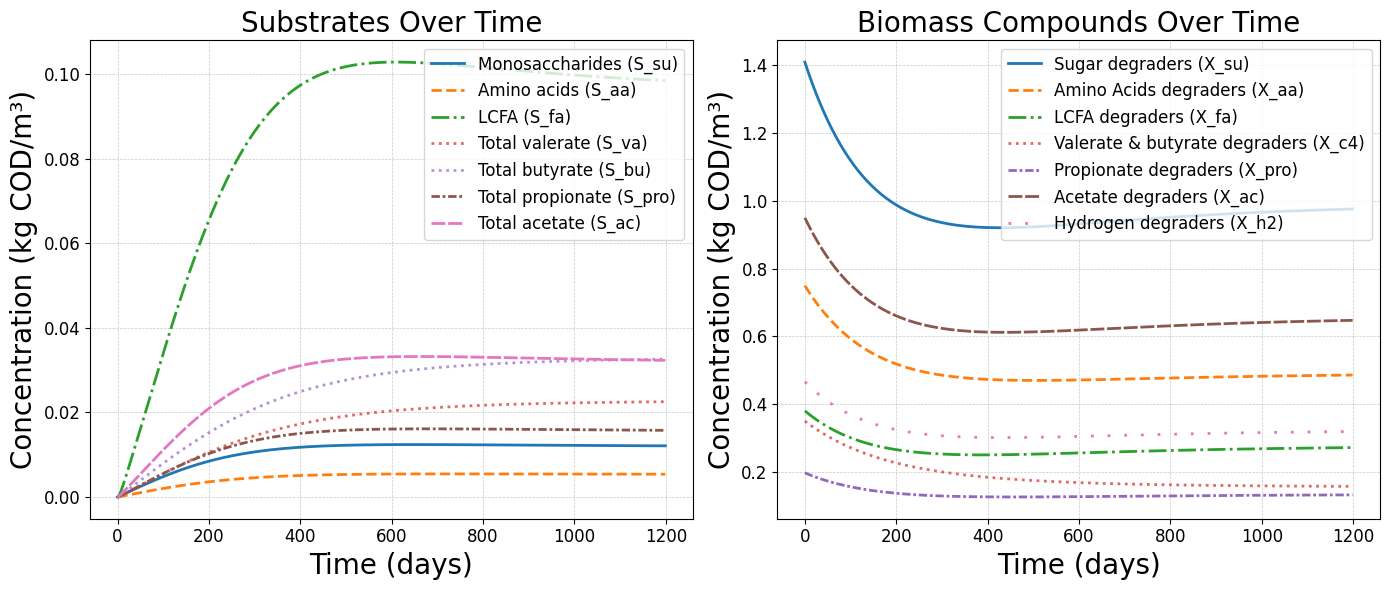

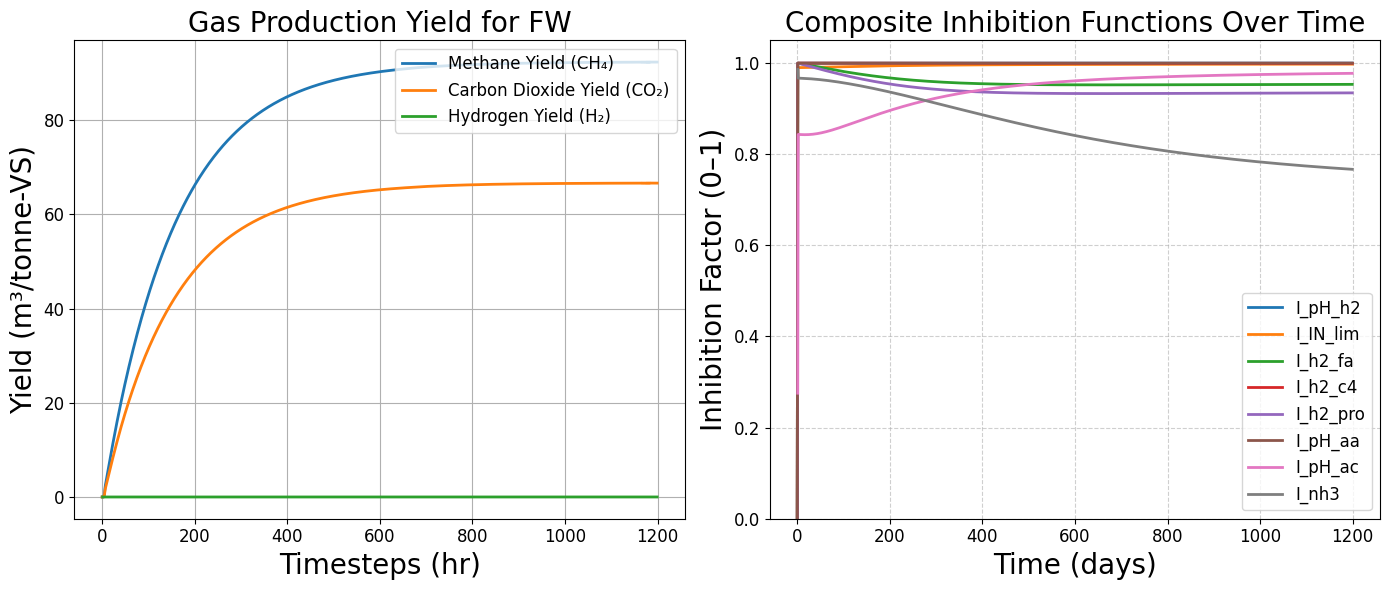

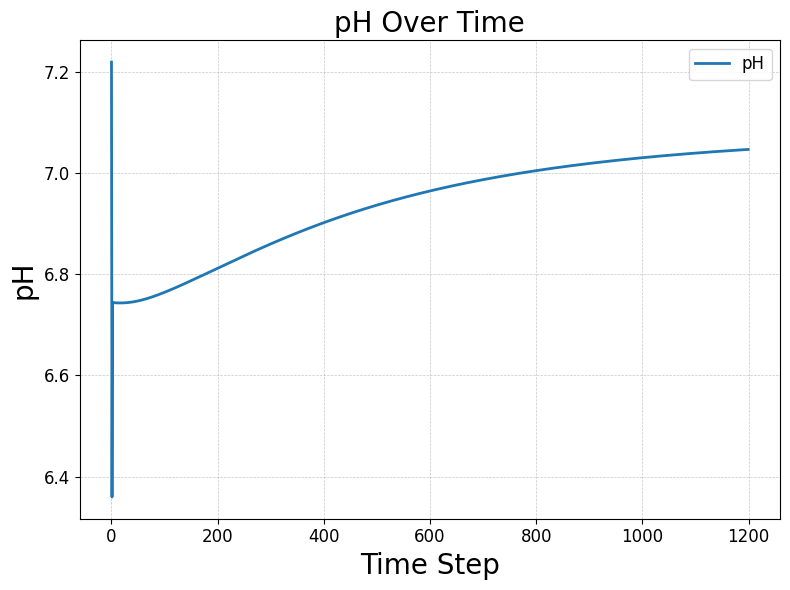

In [25]:
# Plot biomass and substrate compounds with complete names in legend
plot_biomass_and_substrate(simulate_results)

# Plot gas production and inhibition functions with complete names in legend
plot_gas_and_inhibition(gasflow, inhibition)

# Plot pH over time with complete name in legend
plot_ph(simulate_results)